In [34]:
import boto3
import botocore
import sagemaker
import json
from sagemaker import get_execution_role
from glob import glob 

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
import seaborn as sns



import math 

from sklearn.metrics import mean_squared_error
from fbprophet import Prophet


In [35]:
#conda install -c conda-forge fbprophet

In [36]:
from sagemaker import get_execution_role
role = get_execution_role()

region = boto3.Session().region_name
data_bucket = f"target-project-data"
data_prefix = "target-filtered_01Aug2021_1627794515692"

output_bucket = sagemaker.Session().default_bucket()
output_prefix = "target-data-output"



In [37]:


data_filename = "target-filtered_01Aug2021_1627794515692_part00000.csv"
s3 = boto3.client("s3")
s3.download_file(data_bucket, f"{data_prefix}/{data_filename}", data_filename)
target_data = pd.read_csv(data_filename, delimiter=",")

In [38]:
target_data.head()

,TCIN,PRODUCT_TITLE,PRODUCT_DESCRIPTION,BRAND_NAME,BRAND_MANUFACTURER,PRODUCT_CATEGORY_CLASSIFICATION_NAME,ITEM_TYPE_NAME,PRODUCT_TYPE_NAME,MAX_ORDER_QTY,RATING_AVERAGE_OVERALL,DATE_o,TCIN_o,UNITS_SOLD_o,UNITS_RESTOCKED_o,AVAILIBLE_QUANTITY_o,CURRENT_PRICE_o
0,15086744,Yogi Tea Honey Lavender Stress Relief Tea 16ct,Tea Type: Non-Caffeinated,"Features: No Artificial Sweeteners, No Artific...",Form: Loose,Net weight: 1.02 Ounces],Chamomile,bring water to boiling and steep 7 minutes. F...,NaN,90.0,2020-12-25 00:00:00.0,15086744,10.0,9161,4.0,0
1,54221667,Tostitos Lightly Salted Restaurant Style Torti...,"Features: No Added MSG, No Preservatives, No A...","Dietary Needs: Gluten Free, Certified Gluten F...",State of Readiness: Ready to Eat,TOSTITOS are more than tortilla chips and dips...,sizes and flavors,and Tostitos dips are so creamy,71.0,20.0,2020-12-25 00:00:00.0,54221667,NaN,6284,3.0,4
2,79428462,The War Queens by Jonathan W Jordan Emily A...,Genre: History,Sub-Genre: Women,Publisher: Diversion Books,a father-daughter duo charges into combat . ....,and powerfully that strong-willed women have ...,that the female of the species is more deadly...,NaN,NaN,2020-12-25 00:00:00.0,79428462,0.0,362,13.0,0
3,76396424,The Natural Light Portrait Book by Scott Kel...,Genre: Photography,Sub-Genre: Techniques,Publisher: Rocky Nook,indoors or out,Wait a minute,as he discusses everything from his essential...,NaN,99999.0,2020-12-25 00:00:00.0,76396424,0.0,3988,22.0,0
4,53630181,Wall Mounted AV Component Shelving System 1 S...,Material: Metal (Frame),Weight: 4.4 Pounds,"Assembly Details: Adult Assembly Required, Too...",The AS100-A is an AV wall shelf unit with one ...,DVR,DVD,NaN,NaN,2020-12-25 00:00:00.0,53630181,0.0,820,16.0,0


In [39]:
df = target_data

# Do we have enough Shampoo Sales to use only that? 

In [40]:
df2 = df[df["PRODUCT_TITLE"].str.contains("Shampoo")==True]
df2.head(50)

,TCIN,PRODUCT_TITLE,PRODUCT_DESCRIPTION,BRAND_NAME,BRAND_MANUFACTURER,PRODUCT_CATEGORY_CLASSIFICATION_NAME,ITEM_TYPE_NAME,PRODUCT_TYPE_NAME,MAX_ORDER_QTY,RATING_AVERAGE_OVERALL,DATE_o,TCIN_o,UNITS_SOLD_o,UNITS_RESTOCKED_o,AVAILIBLE_QUANTITY_o,CURRENT_PRICE_o
604,53741664,Hoover SmartWash Automatic Carpet Cleaner Mach...,Weight: 18.5 Pounds,"Features: Cord Wrap, Removable Tank, Separate ...",CableCord Length: 22 Feet,Recommended Product Application: Floor,Battery: No Battery Used,Whether its a juice stain or a shoe mark on yo...,NaN,NaN,2020-12-25 00:00:00.0,53741664,NaN,2223,229.0,59
667,13374239,John Frieda Brilliant Brunette MultiTone Color...,"Health Facts: Paraben-Free, Dye-Free, Aluminum...",Product Form: Gel,This shampoo Cleanses and protects colour-trea...,and mirror-like shine. With daily use,hydrated and vibrant. Apply to wet hair and w...,use with John Frieda Brilliant Brunette Multi...,NaN,NaN,2020-12-25 00:00:00.0,13374239,NaN,5645,7.0,173
678,51180413,Pantene Gold Series Moisture Boost Shampoo 91...,All Hair Types,Textured,Beauty Purpose: Moisturizing],5cvbk,[{id:3872918,vendor_name:PROCTER & GAMBLE DIST LLC,NaN,NaN,2020-12-25 00:00:00.0,51180413,NaN,1220,6.0,36
681,80022895,L39Oreal Paris Source Essentielle Nourishing S...,Product Form: Liquid,Beauty Purpose: Basic Cleansing],and silicon free for a natural hair feel afte...,54uos,[{id:1332036,vendor_name:TBC ENTERPRISES INC,NaN,NaN,2020-12-25 00:00:00.0,80022895,0.0,7147,10.0,0
1091,75574623,Hask Chia Seed Volumizing Dry Shampoo 63 fl oz,"Health Facts: Sulfate-Free, Phthalate-Free, Pa...",Product Form: Aerosol,"Beauty Purpose: Oil Control, Volumizing]",only the best formulas for you. <br ><br >At ...,tested for efficacy and formulated without th...,Phthalates,NaN,NaN,2020-12-25 00:00:00.0,75574623,NaN,3463,5.0,35
1999,13374239,John Frieda Brilliant Brunette MultiTone Color...,"Health Facts: Paraben-Free, Dye-Free, Aluminum...",Product Form: Gel,This shampoo Cleanses and protects colour-trea...,and mirror-like shine. With daily use,hydrated and vibrant. Apply to wet hair and w...,use with John Frieda Brilliant Brunette Multi...,NaN,NaN,2020-12-26 00:00:00.0,13374239,77.0,5124,7.0,0
2010,51180413,Pantene Gold Series Moisture Boost Shampoo 91...,All Hair Types,Textured,Beauty Purpose: Moisturizing],5cvbk,[{id:3872918,vendor_name:PROCTER & GAMBLE DIST LLC,NaN,NaN,2020-12-26 00:00:00.0,51180413,16.0,1136,6.0,0
2013,80022895,L39Oreal Paris Source Essentielle Nourishing S...,Product Form: Liquid,Beauty Purpose: Basic Cleansing],and silicon free for a natural hair feel afte...,54uos,[{id:1332036,vendor_name:TBC ENTERPRISES INC,NaN,NaN,2020-12-26 00:00:00.0,80022895,0.0,7147,10.0,0
2180,53741664,Hoover SmartWash Automatic Carpet Cleaner Mach...,Weight: 18.5 Pounds,"Features: Cord Wrap, Removable Tank, Separate ...",CableCord Length: 22 Feet,Recommended Product Application: Floor,Battery: No Battery Used,Whether its a juice stain or a shoe mark on yo...,NaN,NaN,2020-12-26 00:00:00.0,53741664,27.0,2033,229.0,0
3123,75574623,Hask Chia Seed Volumizing Dry Shampoo 63 fl oz,"Health Facts: Sulfate-Free, Phthalate-Free, Pa...",Product Form: Aerosol,"Beauty Purpose: Oil Control, Volumizing]",only the best formulas for you. <br ><br >At ...,tested for efficacy and formulated without th...,Phthalates,NaN,NaN,2020-12-26 00:00:00.0,75574623,14.0,3186,5.0,0


In [55]:
df2.shape



(225, 16)

In [56]:
# No, 225 isn't enough

In [41]:
df.shape

(94200, 16)

(225, 16)

In [44]:
aggregation_functions = {'UNITS_SOLD_o' : 'sum', 'UNITS_RESTOCKED_o' : 'sum', 'AVAILIBLE_QUANTITY_o': 'sum' , 'CURRENT_PRICE_o' : 'sum'}
df_dailysales = df.groupby(df['DATE_o'], as_index=False).aggregate(aggregation_functions).reindex(columns=df.columns)

In [45]:
df_dailysales.shape

(25, 16)

In [46]:
df_dailysales = df_dailysales.drop(columns=['TCIN' , 'PRODUCT_TITLE', 'PRODUCT_DESCRIPTION', 'BRAND_NAME', 'BRAND_MANUFACTURER', 'PRODUCT_CATEGORY_CLASSIFICATION_NAME', 'ITEM_TYPE_NAME', 'PRODUCT_TYPE_NAME', 'MAX_ORDER_QTY', 'RATING_AVERAGE_OVERALL', 'TCIN_o'])

# 

In [47]:
df_dailysales.head()

,DATE_o,UNITS_SOLD_o,UNITS_RESTOCKED_o,AVAILIBLE_QUANTITY_o,CURRENT_PRICE_o
0,2020-10-08 00:00:00.0,1.0,33518,373.0,3
1,2020-10-22 00:00:00.0,200.0,775038,17029.0,1361
2,2020-10-23 00:00:00.0,1371.0,1412975,25443.0,329
3,2020-10-25 00:00:00.0,7612.0,5520566,128074.0,3945
4,2020-10-26 00:00:00.0,15602.0,17753572,374935.0,33001


# Time-Series Forecast

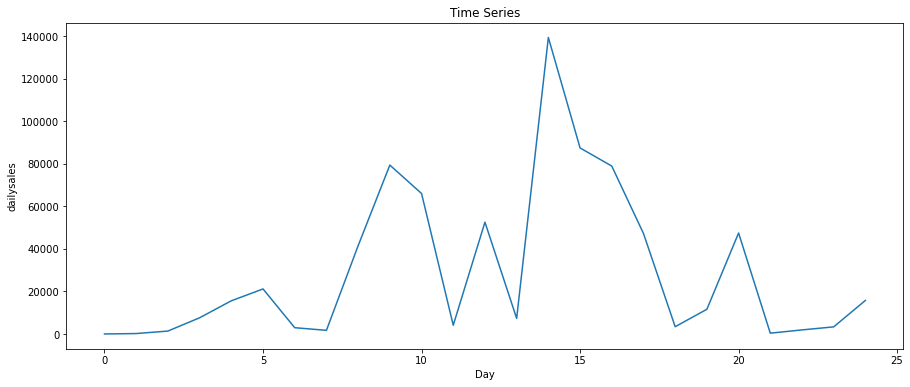

In [48]:
plt.figure(figsize=(15,6))
plt.plot(df_dailysales.UNITS_SOLD_o)

plt.title('Time Series')
plt.xlabel('Day')
plt.ylabel('dailysales')
plt.show()


In [49]:
df_dailysales['ds']= pd.to_datetime(df_dailysales['DATE_o'])
df_dailysales['y']= df_dailysales['UNITS_SOLD_o']

# create new df with 2 columns
data2 = df_dailysales[['ds', 'y']]

data2.head()

,ds,y
0,2020-10-08,1.0
1,2020-10-22,200.0
2,2020-10-23,1371.0
3,2020-10-25,7612.0
4,2020-10-26,15602.0


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


MAE: 20209.302


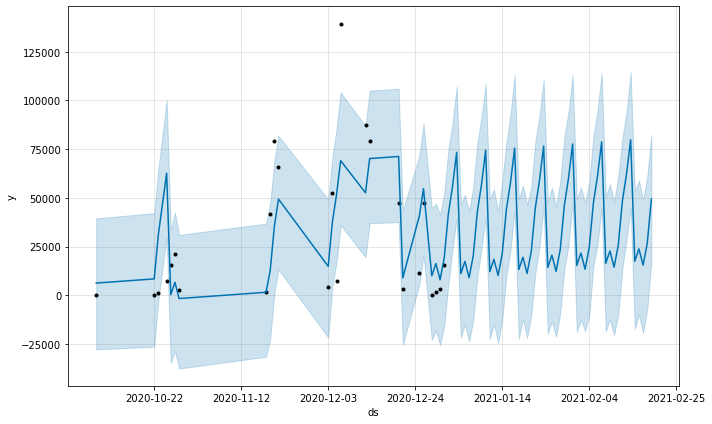

In [50]:
# We are using the Prophet Forecasting tool from Facebook. https://facebook.github.io/prophet/

# initialize model 
model = Prophet()

# fit the model
model.fit(data2)


# check documentation for other freq
future = model.make_future_dataframe(periods=50, freq='D')

# get forecasts using 'predict' function
forecast = model.predict(future)

# plot forecasts
model.plot(forecast);

# calculate forecast error (called yhat in forecast dataframe)
y_true = data2['y'].values
y_pred = forecast['yhat'][:len(y_true)].values
mae = abs(y_true - y_pred).mean()
print('MAE: %.3f' % mae)



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


MAE: 14934.872


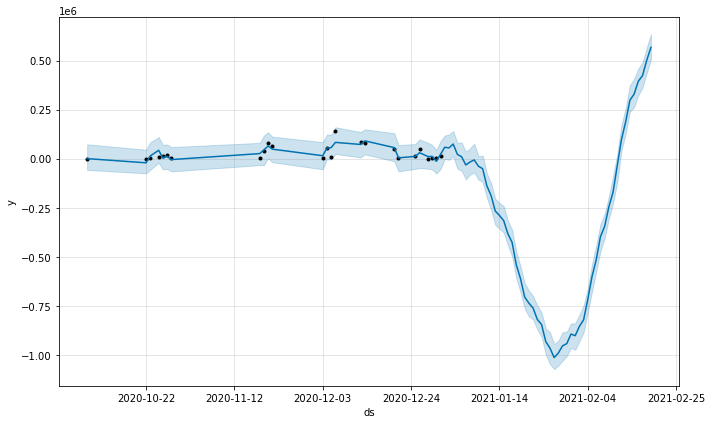

In [51]:
#MODEL version 2- with seasonality

# changepoint_prior_scale: small means less flexble
model2 = Prophet(interval_width=1, yearly_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=0.001)

# add holidays in USA
model2.add_country_holidays(country_name='US')


# fit the model
model2.fit(data2)

# set future periods to forecast
future = model2.make_future_dataframe(periods=50, freq='D')

# get forecasts
forecast = model2.predict(future)

# plot forecasts
model2.plot(forecast);

# calculate forecast error
y_true = data2['y'].values
y_pred = forecast['yhat'][:len(y_true)].values
mae = abs(y_true - y_pred).mean()
print('MAE: %.3f' % mae)

In [54]:
df.to_csv('targetsales.csv')